In [61]:
#import delle librerie necessarie
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from symspellpy import SymSpell, Verbosity
nltk.download('punkt_tab')
import wordcloud
from wordcloud import WordCloud


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pomic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Caricamento e visualizzazione del dataset

In [62]:
#Caricamento e visualizzazione del dataset
dataset = pd.read_csv("../../data/sentiment140_reduced.csv", encoding="ISO-8859-1")
dataset

,target,id,date,flag,user,text
0,0,2205266671,Wed Jun 17 04:21:24 PDT 2009,NO_QUERY,SparkleAndSpunk,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!
1,0,1557952094,Sun Apr 19 06:42:20 PDT 2009,NO_QUERY,TexasTerri,My that's early. I wish I enjoyed mornings mo...
2,0,1972627285,Sat May 30 09:34:54 PDT 2009,NO_QUERY,hippie_420_gurl,Is on her way to get a new pipe. My other broke
3,0,2323727950,Thu Jun 25 01:20:10 PDT 2009,NO_QUERY,Kali23,@DowneyJr you forgot all about me
4,0,2300962221,Tue Jun 23 14:49:12 PDT 2009,NO_QUERY,ApatheticZodiac,"@maria_lovsya boo, what a dirty trick"
...,...,...,...,...,...,...
99995,4,1969622380,Sat May 30 00:38:36 PDT 2009,NO_QUERY,LeonJay,Taking my daughter to the movies. Eating ice c...
99996,4,2014939238,Wed Jun 03 03:11:04 PDT 2009,NO_QUERY,Dynom,"@pierreJoye Yes, a while back. I found it very..."
99997,4,1993793405,Mon Jun 01 10:56:28 PDT 2009,NO_QUERY,VickiElam,"@TTVWineGal Yes, it would have not been a part..."
99998,4,1573170878,Tue Apr 21 00:00:28 PDT 2009,NO_QUERY,pixienay,wants to look at pretty things


# Rimozione colonne non necessarie e conversione del target da 4 a 1 per i tweet positivi

In [63]:
#Modifica del dataset_reduced per la rimozione delle colonne non necessarie
dataset = dataset[['text', 'target']]
dataset = dataset.copy()
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
99995,Taking my daughter to the movies. Eating ice c...,4
99996,"@pierreJoye Yes, a while back. I found it very...",4
99997,"@TTVWineGal Yes, it would have not been a part...",4
99998,wants to look at pretty things,4


In [64]:
#Sostituzione dei valori della colonna 'target': 0 rimane 0 (negativo) e 4 diventa 1 (positivo)
dataset['target'] = dataset['target'].apply(lambda x: 1 if x == 4 else 0)
dataset
#Stampa distribuzione delle classi
print("Distribuzione delle classi:")
print(dataset['target'].value_counts())


Distribuzione delle classi:
target
0    50000
1    50000
Name: count, dtype: int64


# Rimozione duplicati

In [65]:
#Rimozione duplicati individuati durante la fase di data understanding (vengono rimossi i tweet che hanno lo stesso testo di altri)
# Conta il numero totale di duplicati nella colonna 'text'
numero_duplicati = dataset['text'].duplicated().sum()
print("Numero totale di duplicati nella colonna 'text':", numero_duplicati)

# Rimuovi i duplicati
dataset.drop_duplicates(subset='text', inplace=True)

# Conta il numero totale di duplicati nella colonna 'text' dopo la rimozione
numero_duplicati = dataset['text'].duplicated().sum()
print("Numero totale di duplicati nella colonna 'text' dopo la rimozione:", numero_duplicati)

Numero totale di duplicati nella colonna 'text': 296
Numero totale di duplicati nella colonna 'text' dopo la rimozione: 0


In [66]:
#Verifica dell'eliminazione dei 296 duplicati
dataset.shape

(99704, 2)

# Filtraggio tweet con lunghezza anomala

In [67]:
#Visualizza il numero di tweet con lunghezza maggiore di 140 caratteri
print("Numero di tweet con lunghezza maggiore di 140 caratteri:", dataset[dataset['text'].str.len() > 140].shape[0])

#Rimozione dei tweet con lunghezza maggiore di 140 caratteri
dataset = dataset[dataset['text'].str.len() <= 140]

dataset.shape

#Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione
print("Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione:", dataset[dataset['text'].str.len() > 140].shape[0])

Numero di tweet con lunghezza maggiore di 140 caratteri: 995
Numero di tweet con lunghezza maggiore di 140 caratteri dopo la rimozione: 0


In [68]:
#Visualizza il numero di tweet con lunghezza minore di 10 caratteri
print("Numero di tweet con lunghezza minore di 10 caratteri:", dataset[dataset['text'].str.len() < 10].shape[0])

#Stampa tutti i tweet con lunghezza minore di 10 caratteri
print("Tweet con lunghezza minore di 10 caratteri:")
print(dataset[dataset['text'].str.len() < 10]['text'].tolist())

#Rimozione dei tweet con meno di 10 caratteri e che contengono una menzione
def contains_mention(text):
    return bool(re.search(r"@\w+", text))
short_with_mention = dataset[(dataset['text'].str.len() < 10) & (dataset['text'].apply(contains_mention))]

print("Numero di tweet con meno di 10 caratteri e che contengono una menzione:", short_with_mention.shape[0])

dataset = dataset[~((dataset['text'].str.len() < 10) & (dataset['text'].apply(contains_mention)))]

# Numero di tweet con lunghezza minore di 10 caratteri dopo la rimozione
print("Numero di tweet con lunghezza minore di 10 caratteri dopo la rimozione:", dataset[dataset['text'].str.len() < 10].shape[0])

Numero di tweet con lunghezza minore di 10 caratteri: 163
Tweet con lunghezza minore di 10 caratteri:
['headache ', 'selfish ', 'I lied. ', '@gphong ', 'please? ', 'Homework ', 'ow ow ow ', 'Whatever ', 'just  tbh', 'In class ', 'homework ', 'Sunday ', 'br cold! ', 'headace ', 'Sold out ', 'Headache ', 'Revision ', 'so cold ', 'So bored ', 'Still up ', 'pusiiing ', 'Annoyed ', 'My ears ', 'So tired ', 'Tireeed ', '@sheabop ', 'HEADACHE ', 'Waiting ', '@mMmily ', 'Learning ', ' why me?', ' my life', 'Yes I am ', 'cleaning ', 'grounded ', 'i am ill ', 'raining ', 'stressed ', '@rebstew ', 'Work 9-6 ', 'learning ', 'RIP fish ', 'goodbye ', 'Confused ', 'ict....  ', 'bad day ', 'Hangover ', 'restart. ', 'nope... ', 'Over it ', 'Blackout ', 'i is sad ', 'is tired ', 'at work ', 'Hiccups ', 'Workyyyy ', ' is hurty', 'Bad day ', 'am tired ', '@Shazzib ', 'Ugh work ', 'nothing ', 'Bad head ', 'Bad day. ', 'revision ', 'thinking ', 'foooome ', 'painting ', 'LEARNiNG ', ' over it', ' fuck....', 

In [69]:
dataset.shape #Numero di tweet rimanenti

(98691, 2)

In [70]:
#Visualizzazione del dataset dopo la pulizia
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
99995,Taking my daughter to the movies. Eating ice c...,1
99996,"@pierreJoye Yes, a while back. I found it very...",1
99997,"@TTVWineGal Yes, it would have not been a part...",1
99998,wants to look at pretty things,1


In [71]:
#Salvataggio del dataset su cui sarà fatto il training (deve essere fatta ancora la pulizia dei tweet)
dataset.to_csv("../../data/sentiment140_reduced_clean.csv", index=False)

In [72]:
#Caricamento del dataset pulito
dataset = pd.read_csv("../../data/sentiment140_reduced_clean.csv")
dataset

,text,target
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0
1,My that's early. I wish I enjoyed mornings mo...,0
2,Is on her way to get a new pipe. My other broke,0
3,@DowneyJr you forgot all about me,0
4,"@maria_lovsya boo, what a dirty trick",0
...,...,...
98686,Taking my daughter to the movies. Eating ice c...,1
98687,"@pierreJoye Yes, a while back. I found it very...",1
98688,"@TTVWineGal Yes, it would have not been a part...",1
98689,wants to look at pretty things,1



Numero di tweet per ciascuna classe:
0: 49370
1: 49321


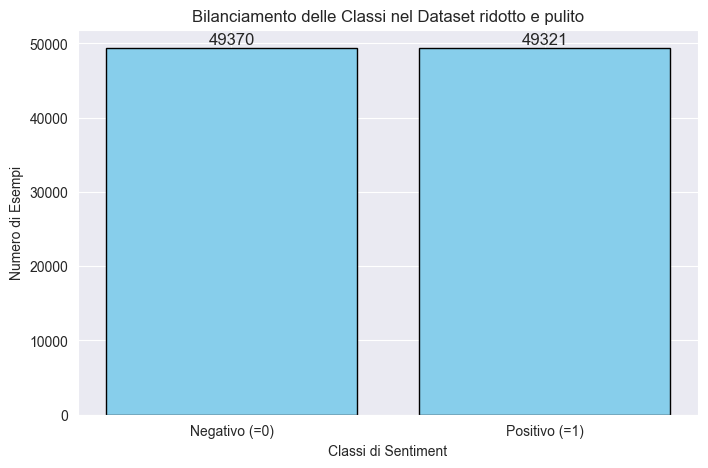

In [73]:
sentiment_counts = dataset['target'].value_counts()

# Stampa del numero di tweet per ciascuna classe
print("\nNumero di tweet per ciascuna classe:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")

# Creazione del diagramma a barre con posizioni corrette
plt.figure(figsize=(8, 5))

bar_positions = range(len(sentiment_counts))
plt.bar(bar_positions, sentiment_counts.values, color='skyblue', edgecolor='black')

# Imposta le etichette personalizzate per l'asse X
plt.xticks(bar_positions, ["Negativo (=0)", "Positivo (=1)"])

plt.xlabel("Classi di Sentiment")
plt.ylabel("Numero di Esempi")
plt.title("Bilanciamento delle Classi nel Dataset ridotto e pulito")

# Aggiunta dei valori sopra le barre
for i, value in enumerate(sentiment_counts.values):
    plt.text(i, value + 500, str(value), ha='center', fontsize=12)

plt.show()

# Pulizia NLP tweet

## Conversione del testo in minuscolo

In [74]:
# Crea una nuova colonna 'text_lower' con il testo convertito in minuscolo
dataset['text_lower'] = dataset['text'].str.lower()

# Visualizza un confronto: prima e dopo la conversione in minuscolo
print("Conversione in Minuscolo (prime 5 righe):\n")
for i, row in dataset[['text', 'text_lower']].head(5).iterrows():
    print("Prima: ", row['text'])
    print("Dopo:  ", row['text_lower'])
    print("-------")

Conversione in Minuscolo (prime 5 righe):

Prima:  @SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED! 
Dopo:   @sushideathno1 - bã¶ã¶ã¶ã¶ll... i'm bored! 
-------
Prima:  My that's early.  I wish I enjoyed mornings more. So much more of a night person so stay up too late and still forced to get up in the AM.
Dopo:   my that's early.  i wish i enjoyed mornings more. so much more of a night person so stay up too late and still forced to get up in the am.
-------
Prima:  Is on her way to get a new pipe. My other broke 
Dopo:   is on her way to get a new pipe. my other broke 
-------
Prima:  @DowneyJr you forgot all about me 
Dopo:   @downeyjr you forgot all about me 
-------
Prima:  @maria_lovsya boo, what a dirty trick 
Dopo:   @maria_lovsya boo, what a dirty trick 
-------


## Rimozione degli URL

In [75]:
# Funzione per rimuovere gli URL
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Applica la funzione sul testo in minuscolo
dataset['text_no_url'] = dataset['text_lower'].apply(remove_urls)

# Seleziona solo le righe che contenevano almeno un URL prima della trasformazione
dataset_with_urls = dataset[dataset['text_lower'].str.contains(r'http\S+|www\S+', regex=True, na=False)]

# Visualizza 5 esempi di tweet che contenevano un URL prima della pulizia
print("Rimozione degli URL (5 righe con URL originali):\n")
for i, row in dataset_with_urls[['text_lower', 'text_no_url']].head(5).iterrows():
    print("Prima: ", row['text_lower'])
    print("Dopo:  ", row['text_no_url'])
    print("-------")


Rimozione degli URL (5 righe con URL originali):

Prima:  rob williams is anchored/docked at  work  http://bit.ly/1psoz8
Dopo:   rob williams is anchored/docked at  work  
-------
Prima:  @xbllygbsn aah alright ;) lol. a know, but a dont wanna get it wrong either  lol :$ aaah alright, makes sence now... http://bit.ly/5avnw
Dopo:   @xbllygbsn aah alright ;) lol. a know, but a dont wanna get it wrong either  lol :$ aaah alright, makes sence now... 
-------
Prima:  @drew hang in there dude.  http://bit.ly/17ruwc #blamedrewscancer
Dopo:   @drew hang in there dude.   #blamedrewscancer
-------
Prima:  oh: fml jeanette mccurdy from icarly is almost 3 months older than me  http://tinyurl.com/ksp9z6
Dopo:   oh: fml jeanette mccurdy from icarly is almost 3 months older than me  
-------
Prima:  @ppphilip ahahaha awww.  it's okee.  i would say do it at school, but they just blocked it  twitter loves ppphilip.
Dopo:   @ppphilip ahahaha a  it's okee.  i would say do it at school, but they just bloc

## Rimozione delle menzioni

In [76]:
# Funzione per rimuovere le menzioni (@username)
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

# Applica la funzione sul testo già privo di URL
dataset['text_no_mentions'] = dataset['text_no_url'].apply(remove_mentions)

# Seleziona solo le righe che contenevano almeno una menzione prima della trasformazione
dataset_with_mentions = dataset[dataset['text_no_url'].str.contains(r'@\w+', regex=True, na=False)]

# Visualizza 5 esempi di tweet che contenevano una menzione prima della pulizia
print("Rimozione delle menzioni (5 righe con menzioni originali):\n")
for i, row in dataset_with_mentions[['text_no_url', 'text_no_mentions']].head(5).iterrows():
    print("Prima: ", row['text_no_url'])
    print("Dopo:  ", row['text_no_mentions'])
    print("-------")

Rimozione delle menzioni (5 righe con menzioni originali):

Prima:  @sushideathno1 - bã¶ã¶ã¶ã¶ll... i'm bored! 
Dopo:    - bã¶ã¶ã¶ã¶ll... i'm bored! 
-------
Prima:  @downeyjr you forgot all about me 
Dopo:    you forgot all about me 
-------
Prima:  @maria_lovsya boo, what a dirty trick 
Dopo:    boo, what a dirty trick 
-------
Prima:  @jwalsh damnit all. that sucks.  you were one of the ones i thought i'd drag back lol
Dopo:    damnit all. that sucks.  you were one of the ones i thought i'd drag back lol
-------
Prima:  @missdadecounty you're a bad mama 
Dopo:    you're a bad mama 
-------


## Sostituzione delle entità HTML

In [77]:
# Funzione per sostituire entità HTML:
# - &apos; viene convertito in '
# - Tutte le altre entità (&amp;, &quot;, &lt;, &gt;) vengono rimosse
def replace_html_entities(text):
    text = re.sub(r'&amp;|&quot;|&lt;|&gt;', ' ', text)  # Sostituisci con spazio vuoto
    text = text.replace('&apos;', "'")  # Sostituisci &apos; con apostrofo
    return text

# Applica la funzione sul testo con menzioni già gestite
dataset['text_html_clean'] = dataset['text_no_mentions'].apply(replace_html_entities)

# Filtra solo le righe che contenevano entità HTML nel testo originale
dataset_with_html = dataset[dataset['text_no_mentions'].str.contains(r'&amp;|&quot;|&lt;|&gt;|&apos;', regex=True, na=False)]

# Visualizza 5 esempi: prima (text_no_mentions) e dopo la sostituzione delle entità HTML
print("Sostituzione delle Entità HTML (5 righe con entità HTML):\n")
for i, row in dataset_with_html[['text_no_mentions', 'text_html_clean']].head(5).iterrows():
    print("Prima: ", row['text_no_mentions'])
    print("Dopo:  ", row['text_html_clean'])
    print("-------")

Sostituzione delle Entità HTML (5 righe con entità HTML):

Prima:  man i'm kinda disappointed in &quot;year one&quot;....sad day. 
Dopo:   man i'm kinda disappointed in  year one ....sad day. 
-------
Prima:  off to come up with lazzi's &amp; re-write commerce essay 
Dopo:   off to come up with lazzi's   re-write commerce essay 
-------
Prima:   plz say &quot;happy birthday or , roni &amp; mickey!&quot; plz plz plz  x
Dopo:    plz say  happy birthday or , roni   mickey!  plz plz plz  x
-------
Prima:  saw angels &amp; demons last night. that is a movie inspired by the book, but in no way true to the book. and the final brand? c'mon. 
Dopo:   saw angels   demons last night. that is a movie inspired by the book, but in no way true to the book. and the final brand? c'mon. 
-------
Prima:  argh! facebook is being annoying! or is it the internet connection? &amp; boo, love is cutting his hair. i'll miss that hair of his 
Dopo:   argh! facebook is being annoying! or is it the internet connec

## Rilevamento emoji testuali e sostituzione con una singola parola

In [78]:
# Dizionario delle emoji testuali sostituite con una singola parola
emoji_dict = {
    ":)": "happy",
    ":-)": "happy",
    ":D": "joyful",
    ":-D": "joyful",
    ":(": "sad",
    ":-(": "sad",
    ";)": "wink",
    ";-)": "wink",
    ":P": "playful",
    ":-P": "playful",
    ":'(": "crying",
    ":-'(": "crying",
    "XD": "laughing",
    "xD": "laughing",
    ":-|": "neutral",
    ":|": "neutral"
}

def replace_text_emojis(text):
    """Sostituisce le emoji testuali con una singola parola."""
    for emoji, meaning in emoji_dict.items():
        text = re.sub(re.escape(emoji), meaning, text)
    return text

# Applica la funzione sul testo pulito senza elementi HTML
dataset['text_no_emojis'] = dataset['text_html_clean'].apply(replace_text_emojis)

# Seleziona solo le righe che contenevano almeno una emoji testuale
dataset_with_emojis = dataset[dataset['text_html_clean'].str.contains('|'.join(map(re.escape, emoji_dict.keys())), regex=True, na=False)]

# Visualizza 5 esempi di tweet che contenevano emoji testuali prima della pulizia
print("Sostituzione delle Emoji Testuali (5 righe con emoji testuali originali):\n")
for i, row in dataset_with_emojis[['text_html_clean', 'text_no_emojis']].head(5).iterrows():
    print("Prima: ", row['text_html_clean'])
    print("Dopo:  ", row['text_no_emojis'])
    print("-------")



Sostituzione delle Emoji Testuali (5 righe con emoji testuali originali):

Prima:   aah alright ;) lol. a know, but a dont wanna get it wrong either  lol :$ aaah alright, makes sence now... 
Dopo:    aah alright wink lol. a know, but a dont wanna get it wrong either  lol :$ aaah alright, makes sence now... 
-------
Prima:    hehe thaaaanks abbii! ;) ooh! btw your hair is sooooo cool! i love it!
Dopo:     hehe thaaaanks abbii! wink ooh! btw your hair is sooooo cool! i love it!
-------
Prima:   aweh   that sucks / amd wowww mileey your such a nice sister ;) teehe , but its true '' it will make a cool scar '' love you !
Dopo:    aweh   that sucks / amd wowww mileey your such a nice sister wink teehe , but its true '' it will make a cool scar '' love you !
-------
Prima:   err, might not continue with that  i still have loads of stuff to do :|
Dopo:    err, might not continue with that  i still have loads of stuff to do neutral
-------
Prima:  emhen29; bahahha i'm lovin vodka tonight too..

## Rimozione degli hashtag

In [79]:
# Funzione per gestire gli hashtag: rimuoviamo solo il simbolo '#' mantenendo la parola
def remove_hashtag_symbol(text):
    return re.sub(r'#', '', text)

# Applica la funzione sul testo già privo di emoji testuali
dataset['text_hashtag_clean'] = dataset['text_no_emojis'].apply(remove_hashtag_symbol)

# Seleziona solo le righe che contenevano almeno un hashtag prima della trasformazione
dataset_with_hashtags = dataset[dataset['text_no_emojis'].str.contains(r'#\w+', regex=True, na=False)]

# Visualizza 5 esempi di tweet che contenevano un hashtag prima della pulizia
print("Gestione degli Hashtag (5 righe con Hashtag originali):\n")
for i, row in dataset_with_hashtags[['text_no_emojis', 'text_hashtag_clean']].head(5).iterrows():
    print("Prima: ", row['text_no_emojis'])
    print("Dopo:  ", row['text_hashtag_clean'])
    print("-------")


Gestione degli Hashtag (5 righe con Hashtag originali):

Prima:  this is the scariest storm ever! i have never heard thunder like this.  #squarespace
Dopo:   this is the scariest storm ever! i have never heard thunder like this.  squarespace
-------
Prima:   hang in there dude.   #blamedrewscancer
Dopo:    hang in there dude.   blamedrewscancer
-------
Prima:  : *personally confirmed from #iran* tanks have rolled in tehran ... #iranelection #gr88 flash back to '79   (via )
Dopo:   : *personally confirmed from iran* tanks have rolled in tehran ... iranelection gr88 flash back to '79   (via )
-------
Prima:   reading your   h's excellent adventure gives nightmares-will be sanantonia 4 me in aug w/quick change in salt lake  #hhrs
Dopo:    reading your   h's excellent adventure gives nightmares-will be sanantonia 4 me in aug w/quick change in salt lake  hhrs
-------
Prima:   no #followfriday love for the #phenom?  ? 
Dopo:    no followfriday love for the phenom?  ? 
-------


## Espansione delle abbreviazioni

In [80]:
# Creiamo un dizionario di abbreviazioni comuni
abbr_dict = {
    "u": "you", "r": "are", "pls": "please", "idk": "I do not know", "omg": "oh my god",
    "btw": "by the way", "gr8": "great", "lol": "laughing out loud", "brb": "be right back",
    "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing", "smh": "shaking my head",
    "fyi": "for your information", "tbh": "to be honest", "np": "no problem", "imo": "in my opinion",
    "imho": "in my humble opinion", "wtf": "what the fuck", "wth": "what the hell", "gg": "good game",
    "bff": "best friends forever", "ftw": "for the win", "afk": "away from keyboard", "nvm": "never mind",
    "ttyl": "talk to you later", "ikr": "I know, right?", "jk": "just kidding", "idc": "I do not care",
    "hmu": "hit me up", "wyd": "what you doing", "wbu": "what about you", "g2g": "got to go",
    "ty": "thank you", "yw": "you are welcome", "thx": "thanks", "yolo": "you only live once",
    "xoxo": "hugs and kisses", "bday": "birthday", "omw": "on my way", "pov": "point of view",
    "ily": "I love you", "ilu": "I love you", "dm": "direct message", "ggwp": "good game well played",
    "mfw": "my face when", "tfw": "that feeling when", "tldr": "too long did not read", "b4": "before",
    "bc": "because", "b/c": "because", "cuz": "because", "msg": "message", "fml": "fuck my life",
    "fb": "Facebook", "ig": "Instagram", "twt": "Twitter", "faq": "frequently asked questions",
    "rip": "rest in peace", "irl": "in real life", "otp": "one true pairing", "hbd": "happy birthday",
    "grats": "congratulations", "ez": "easy", "glhf": "good luck have fun", "w/": "with",
    "w/o": "without", "bffl": "best friends for life", "bby": "baby", "bbygirl": "baby girl",
    "bbyboy": "baby boy", "tba": "to be announced", "tbc": "to be confirmed", "lmk": "let me know",
    "wdym": "what do you mean", "ttys": "talk to you soon", "tf": "the fuck", "wt": "what",
    "bcuz": "because", "wym": "what you mean", "fr": "for real", "rn": "right now",
    "prolly": "probably", "jfc": "jesus fucking christ", "stg": "swear to god", "ntm": "not too much",
    "smdh": "shaking my damn head", "lil": "little", "b": "be", "ttyn": "talk to you never",
    "dunno": "do not know", "goat": "greatest of all time", "tbf": "to be fair",
    "ffs": "for fuck's sake", "its": "it is"
}

# Funzione per espandere le abbreviazioni
def expand_abbreviations(text, abbr_dict):
    tokens = text.split()
    expanded_tokens = [abbr_dict.get(token, token) for token in tokens]
    return " ".join(expanded_tokens)

# Crea una nuova colonna con il testo espanso
dataset['text_abbr_expanded'] = dataset['text_hashtag_clean'].apply(lambda x: expand_abbreviations(x, abbr_dict))

# Filtra solo i tweet che contenevano almeno un'abbreviazione
dataset_abbr_filtered = dataset[dataset['text_hashtag_clean'].apply(lambda x: any(word in abbr_dict for word in x.split()))]

# Visualizza il confronto solo per le righe che hanno subito una modifica
print("Espansione delle Abbreviazioni (solo righe con abbreviazioni):\n")
for i, row in dataset_abbr_filtered[['text_hashtag_clean', 'text_abbr_expanded']].head(10).iterrows():
    print("Prima: ", row['text_hashtag_clean'])
    print("Dopo:  ", row['text_abbr_expanded'])
    print("-------")


Espansione delle Abbreviazioni (solo righe con abbreviazioni):

Prima:   damnit all. that sucks.  you were one of the ones i thought i'd drag back lol
Dopo:   damnit all. that sucks. you were one of the ones i thought i'd drag back laughing out loud
-------
Prima:   i wrote a leadership essay abt its founder. the expansion didn't went well, tried to break in america. lots of money burned. 
Dopo:   i wrote a leadership essay abt it is founder. the expansion didn't went well, tried to break in america. lots of money burned.
-------
Prima:  omg the hm movie is amazing its soo *.* (:     i thought you were frequently in the movie  but it was so great (:
Dopo:   oh my god the hm movie is amazing it is soo *.* (: i thought you were frequently in the movie but it was so great (:
-------
Prima:   take me with you i didn't get any tix  lol
Dopo:   take me with you i didn't get any tix laughing out loud
-------
Prima:   aah alright wink lol. a know, but a dont wanna get it wrong either  lol :$ a

## Espansione delle contrazioni

In [81]:
# Funzione per espandere le contrazioni usando la libreria
def expand_contractions_lib(text):
    return contractions.fix(text)

# Applica la funzione di espansione
dataset['text_contractions_expanded'] = dataset['text_abbr_expanded'].apply(expand_contractions_lib)

# Seleziona solo le righe in cui il testo è cambiato
changed_rows = dataset[dataset['text_abbr_expanded'] != dataset['text_contractions_expanded']]

# Mostra solo le righe con differenze
print("Espansione delle Contrazioni con Libreria (solo righe modificate):\n")
for i, row in changed_rows[['text_abbr_expanded', 'text_contractions_expanded']].head(10).iterrows():
    print("Prima: ", row['text_abbr_expanded'])
    print("Dopo:  ", row['text_contractions_expanded'])
    print("-------")

Espansione delle Contrazioni con Libreria (solo righe modificate):

Prima:  - bã¶ã¶ã¶ã¶ll... i'm bored!
Dopo:   - bã¶ã¶ã¶ã¶ll... i am bored!
-------
Prima:  my that's early. i wish i enjoyed mornings more. so much more of a night person so stay up too late and still forced to get up in the am.
Dopo:   my that is early. i wish i enjoyed mornings more. so much more of a night person so stay up too late and still forced to get up in the am.
-------
Prima:  oh no. im having a coughing fit
Dopo:   oh no. i am having a coughing fit
-------
Prima:  damnit all. that sucks. you were one of the ones i thought i'd drag back laughing out loud
Dopo:   damnit all. that sucks. you were one of the ones i thought i would drag back laughing out loud
-------
Prima:  you're a bad mama
Dopo:   you are a bad mama
-------
Prima:  i wrote a leadership essay abt it is founder. the expansion didn't went well, tried to break in america. lots of money burned.
Dopo:   i wrote a leadership essay about it is founder

## Rimozione della punteggiatura e caratteri speciali (rimangono solo lettere numeri e spazi)

In [82]:
# Funzione per rimuovere caratteri speciali (manteniamo solo lettere, numeri e spazi)
def remove_special_chars(text):
    # Modifica: rimuove tutto ciò che non è una lettera (a-z, A-Z) o uno spazio (\s)
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

# Applica la funzione sul testo già pulito dalle contrazioni espanse
dataset['text_no_special'] = dataset['text_contractions_expanded'].apply(remove_special_chars)

# Confronto: prima (text_contractions_expanded) e dopo la rimozione di caratteri speciali e numeri
print("Rimozione di Caratteri Speciali e Numeri (prime 7 righe):\n")
for i, row in dataset[['text_contractions_expanded', 'text_no_special']].head(7).iterrows():
    print("Prima: ", row['text_contractions_expanded'])
    print("Dopo:  ", row['text_no_special'])
    print("-------")

Rimozione di Caratteri Speciali e Numeri (prime 7 righe):

Prima:  - bã¶ã¶ã¶ã¶ll... i am bored!
Dopo:     b        ll    i am bored 
-------
Prima:  my that is early. i wish i enjoyed mornings more. so much more of a night person so stay up too late and still forced to get up in the am.
Dopo:   my that is early  i wish i enjoyed mornings more  so much more of a night person so stay up too late and still forced to get up in the am 
-------
Prima:  is on her way to get a new pipe. my other broke
Dopo:   is on her way to get a new pipe  my other broke
-------
Prima:  you forgot all about me
Dopo:   you forgot all about me
-------
Prima:  boo, what a dirty trick
Dopo:   boo  what a dirty trick
-------
Prima:  this is the scariest storm ever! i have never heard thunder like this. squarespace
Dopo:   this is the scariest storm ever  i have never heard thunder like this  squarespace
-------
Prima:  sigh my pc crashed.. need to find someone to fix it!!
Dopo:   sigh my pc crashed   need to find

## Correzione ortografica

In [83]:
# Parametri per symspellpy
max_edit_distance = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance, prefix_length)

dictionary_path = "../../data/frequency_dictionary_en_82_765.txt"
term_index = 0   # La parola
count_index = 1  # La frequenza

if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
    print("Errore nel caricamento del dizionario!")

def correct_spelling_symspell(text):
    tokens = text.split()
    corrected_tokens = []
    for token in tokens:
        # Lookup del token con il livello di verbosità CLOSEST per ottenere la correzione migliore
        suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance)
        if suggestions:
            # Se sono presenti suggerimenti, prendiamo il migliore (primo elemento)
            corrected_tokens.append(suggestions[0].term)
        else:
            # Altrimenti, manteniamo il token originale
            corrected_tokens.append(token)
    return " ".join(corrected_tokens)

# Applica la correzione ortografica sulla colonna ottenuta dalla rimozione dei caratteri speciali e punteggiatura
dataset['text_spell_corrected'] = dataset['text_no_special'].apply(correct_spelling_symspell)

corrections = dataset[dataset['text_no_special'] != dataset['text_spell_corrected']]

# Seleziona un numero limitato di esempi per la visualizzazione
num_examples = 20
corrections_sample = corrections[['text_no_special', 'text_spell_corrected']].head(num_examples)

# Stampa le correzioni effettive
print("Esempi di correzioni ortografiche effettuate da SymSpell:\n")
for i, row in corrections_sample.iterrows():
    print("Prima: ", row['text_no_special'])
    print("Dopo:  ", row['text_spell_corrected'])
    print("-------")


Esempi di correzioni ortografiche effettuate da SymSpell:

Prima:    b        ll    i am bored 
Dopo:   a all i am bored
-------
Prima:  my that is early  i wish i enjoyed mornings more  so much more of a night person so stay up too late and still forced to get up in the am 
Dopo:   my that is early i wish i enjoyed mornings more so much more of a night person so stay up too late and still forced to get up in they am
-------
Prima:  is on her way to get a new pipe  my other broke
Dopo:   is on her way to get a new pipe my other broke
-------
Prima:  boo  what a dirty trick
Dopo:   boo what a dirty trick
-------
Prima:  this is the scariest storm ever  i have never heard thunder like this  squarespace
Dopo:   this is they scariest storm ever i have never heard thunder like this squarespace
-------
Prima:  sigh my pc crashed   need to find someone to fix it  
Dopo:   sigh my pc crashed need to find someone to fix it
-------
Prima:  wonderfully slow start to the day  but now for shopping 

## Normalizzazione spazi

In [84]:
def normalize_spaces(text):
    # Rimuove spazi multipli e spazi iniziali/finali
    return re.sub(r'\s+', ' ', text).strip()

# Crea una nuova colonna
dataset['text_spaces_clean'] = dataset['text_spell_corrected'].apply(normalize_spaces)

# Confronto (prime 5 righe)
print("Rimozione spazi multipli e trimming:\n")
for i, row in dataset[['text_spell_corrected', 'text_spaces_clean']].head(5).iterrows():
    print("PRIMA ->", row['text_spell_corrected'])
    print("DOPO  ->", row['text_spaces_clean'])
    print("-------------------------------------------------")

Rimozione spazi multipli e trimming:

PRIMA -> a all i am bored
DOPO  -> a all i am bored
-------------------------------------------------
PRIMA -> my that is early i wish i enjoyed mornings more so much more of a night person so stay up too late and still forced to get up in they am
DOPO  -> my that is early i wish i enjoyed mornings more so much more of a night person so stay up too late and still forced to get up in they am
-------------------------------------------------
PRIMA -> is on her way to get a new pipe my other broke
DOPO  -> is on her way to get a new pipe my other broke
-------------------------------------------------
PRIMA -> you forgot all about me
DOPO  -> you forgot all about me
-------------------------------------------------
PRIMA -> boo what a dirty trick
DOPO  -> boo what a dirty trick
-------------------------------------------------


## Tokenizzazione, lemmatizzazione e rimozione delle stopwords

In [85]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenizzazione: divide il testo in parole
    tokens = word_tokenize(text)

    # Lemmatizzazione: ottiene la forma base di ogni token
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    # Rimozione delle stopword: elimina i token che sono presenti nella lista
    tokens_clean = [token for token in tokens_lemmatized if token.lower() not in stop_words]

    return tokens_clean

# Applica il preprocessing su una nuova colonna
dataset['tokens_processed'] = dataset['text_spaces_clean'].apply(preprocess_text)

# Per il confronto, mostra il risultato per alcune righe
print("\nConfronto prima e dopo (Tokenizzazione, Lemmatizzazione e Rimozione Stopword):\n")
for i, row in dataset[['text_spaces_clean', 'tokens_processed']].head(5).iterrows():
    print("Testo originale:", row['text_spaces_clean'])
    print("Token elaborati:", row['tokens_processed'])
    print("-------------------------------------------------")


Confronto prima e dopo (Tokenizzazione, Lemmatizzazione e Rimozione Stopword):

Testo originale: a all i am bored
Token elaborati: ['bored']
-------------------------------------------------
Testo originale: my that is early i wish i enjoyed mornings more so much more of a night person so stay up too late and still forced to get up in they am
Token elaborati: ['early', 'wish', 'enjoyed', 'morning', 'much', 'night', 'person', 'stay', 'late', 'still', 'forced', 'get']
-------------------------------------------------
Testo originale: is on her way to get a new pipe my other broke
Token elaborati: ['way', 'get', 'new', 'pipe', 'broke']
-------------------------------------------------
Testo originale: you forgot all about me
Token elaborati: ['forgot']
-------------------------------------------------
Testo originale: boo what a dirty trick
Token elaborati: ['boo', 'dirty', 'trick']
-------------------------------------------------


## Ricostruzione del testo

In [86]:
# Funzione per ricostruire il testo dai token processati
def reconstruct_text(tokens):
    return " ".join(tokens)

# Crea una nuova colonna con il testo ricostruito
dataset['text_final'] = dataset['tokens_processed'].apply(reconstruct_text)

# Visualizza il confronto tra il testo tokenizzato e il testo ricostruito
print("Confronto tra il testo originale e il testo ricostruito:\n")
for i, row in dataset[['tokens_processed', 'text_final']].head(5).iterrows():
    print("Prima: ", row['tokens_processed'])
    print("Dopo:  ", row['text_final'])
    print("-------")

Confronto tra il testo originale e il testo ricostruito:

Prima:  ['bored']
Dopo:   bored
-------
Prima:  ['early', 'wish', 'enjoyed', 'morning', 'much', 'night', 'person', 'stay', 'late', 'still', 'forced', 'get']
Dopo:   early wish enjoyed morning much night person stay late still forced get
-------
Prima:  ['way', 'get', 'new', 'pipe', 'broke']
Dopo:   way get new pipe broke
-------
Prima:  ['forgot']
Dopo:   forgot
-------
Prima:  ['boo', 'dirty', 'trick']
Dopo:   boo dirty trick
-------


## Analisi word cloud sentiment positivo e negativo

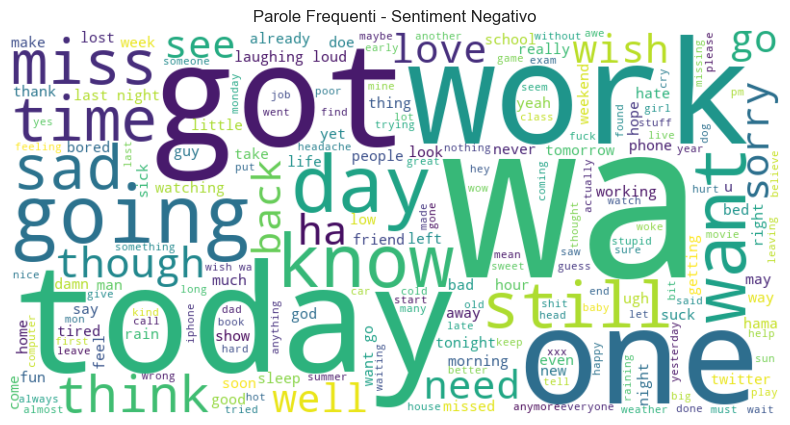

In [87]:
# Seleziona tutti i tweet con target 0 (sentiment negativo) e unisci il testo in un'unica stringa
text_neg = ' '.join(dataset[dataset['target'] == 0]['text_final'])

# Genera la wordcloud per il sentiment negativo
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_neg)

# Visualizza la wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Parole Frequenti - Sentiment Negativo')
plt.axis('off')
plt.show()

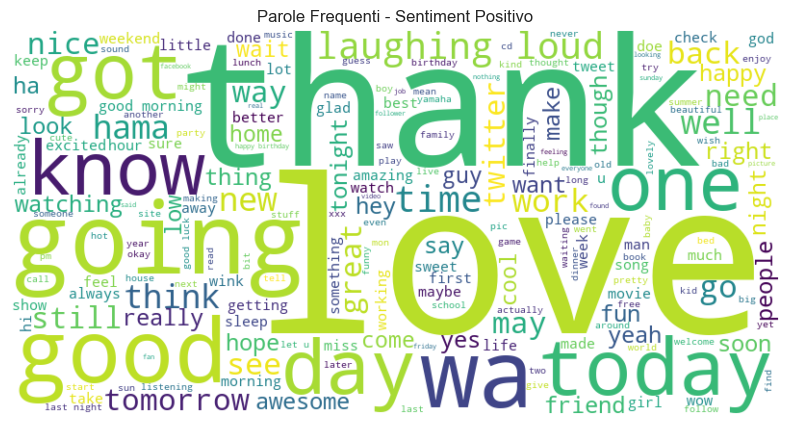

In [88]:
# Seleziona tutti i tweet con target 1 (sentiment positivo) e unisci il testo in un'unica stringa
text_pos = ' '.join(dataset[dataset['target'] == 1]['text_final'])

# Genera la wordcloud per il sentiment positivo
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_pos)

# Visualizza la wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Parole Frequenti - Sentiment Positivo')
plt.axis('off')
plt.show()

## Rimozione parola "wa"

In [89]:
def remove_wa(text):
    return re.sub(r'\bwa\b', '', text)

# Applica la funzione di rimozione della parola "wa"
dataset['text_final_no_wa'] = dataset['text_final'].apply(remove_wa)

# Normalizza nuovamente gli spazi per rimuovere eventuali spazi extra dopo la rimozione
def normalize_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

dataset['text_final_no_wa'] = dataset['text_final_no_wa'].apply(normalize_spaces)

# Filtra il dataset per ottenere solo i tweet che contenevano "wa" prima della rimozione
mask = dataset['text_final'].str.contains(r'\bwa\b', regex=True)

# Seleziona solo le righe che soddisfano la condizione e le colonne per il confronto
df_with_wa = dataset.loc[mask, ['text_final', 'text_final_no_wa']]

# Confronto finale
print("Confronto finale per i tweet che contenevano la parola 'wa':\n")
for i, row in df_with_wa.iterrows():
    print("PRIMA ->", row['text_final'])
    print("DOPO  ->", row['text_final_no_wa'])
    print("-------------------------------------------------")


Confronto finale per i tweet che contenevano la parola 'wa':

PRIMA -> good deal wa able make
DOPO  -> good deal able make
-------------------------------------------------
PRIMA -> god movie amazing thought frequently movie wa great
DOPO  -> god movie amazing thought frequently movie great
-------------------------------------------------
PRIMA -> meet tutti wa great movie good food miss lot miss day chase pm together
DOPO  -> meet tutti great movie good food miss lot miss day chase pm together
-------------------------------------------------
PRIMA -> stupid website hacking twitter doe get follower clicked link wa bit virus
DOPO  -> stupid website hacking twitter doe get follower clicked link bit virus
-------------------------------------------------
PRIMA -> sometimes wish wa black could cosplay geordie cool
DOPO  -> sometimes wish black could cosplay geordie cool
-------------------------------------------------
PRIMA -> nope keep company hama cracking wa lame low
DOPO  -> nope ke

## Analisi word cloud sentiment positivo e negativo

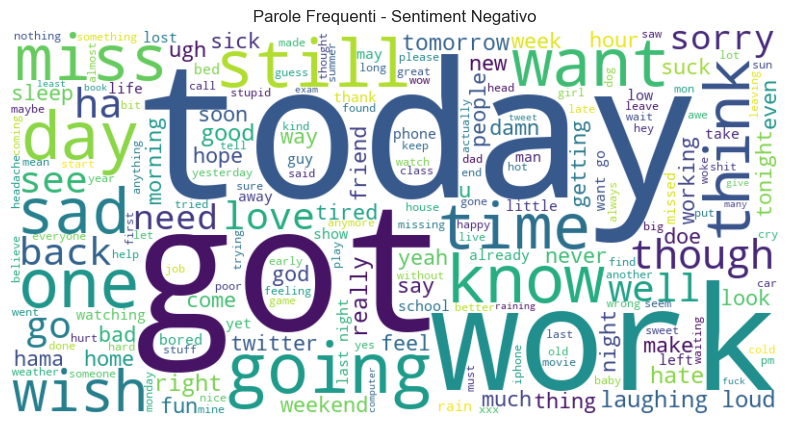

In [90]:
# Seleziona tutti i tweet con target 0 (sentiment negativo) e unisci il testo in un'unica stringa
text_neg = ' '.join(dataset[dataset['target'] == 0]['text_final_no_wa'])

# Genera la wordcloud per il sentiment negativo
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_neg)

# Visualizza la wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Parole Frequenti - Sentiment Negativo')
plt.axis('off')
plt.show()

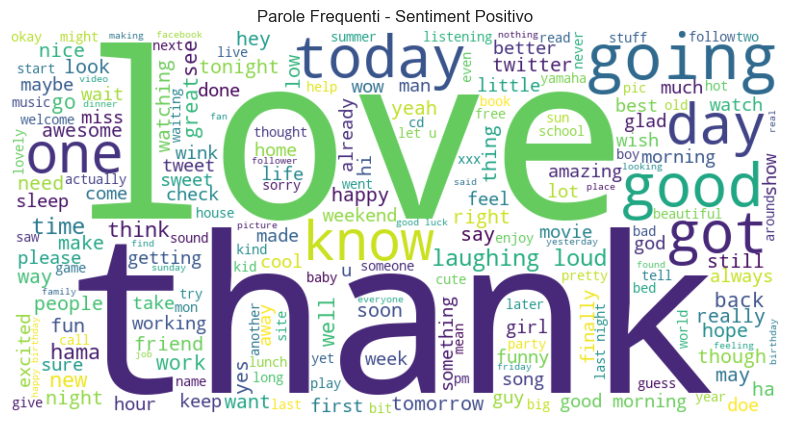

In [91]:
# Seleziona tutti i tweet con target 1 (sentiment positivo) e unisci il testo in un'unica stringa
text_pos = ' '.join(dataset[dataset['target'] == 1]['text_final_no_wa'])

# Genera la wordcloud per il sentiment positivo
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_pos)

# Visualizza la wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Parole Frequenti - Sentiment Positivo')
plt.axis('off')
plt.show()

In [92]:
#Verifica di eventuali tweet vuoti
empty_tweets = dataset[dataset['text_final_no_wa'] == '']
print("Numero di tweet vuoti:", empty_tweets.shape[0])

#Rimozione dei tweet vuoti
dataset = dataset[dataset['text_final_no_wa'] != '']

dataset

Numero di tweet vuoti: 607


,text,target,text_lower,text_no_url,text_no_mentions,text_html_clean,text_no_emojis,text_hashtag_clean,text_abbr_expanded,text_contractions_expanded,text_no_special,text_spell_corrected,text_spaces_clean,tokens_processed,text_final,text_final_no_wa
0,@SushiDeathNo1 - bÃ¶Ã¶Ã¶Ã¶ll... I'M BORED!,0,@sushideathno1 - bã¶ã¶ã¶ã¶ll... i'm bored!,@sushideathno1 - bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i'm bored!,- bã¶ã¶ã¶ã¶ll... i am bored!,b ll i am bored,a all i am bored,a all i am bored,[bored],bored,bored
1,My that's early. I wish I enjoyed mornings mo...,0,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mo...,my that's early. i wish i enjoyed mornings mor...,my that is early. i wish i enjoyed mornings mo...,my that is early i wish i enjoyed mornings mo...,my that is early i wish i enjoyed mornings mor...,my that is early i wish i enjoyed mornings mor...,"[early, wish, enjoyed, morning, much, night, p...",early wish enjoyed morning much night person s...,early wish enjoyed morning much night person s...
2,Is on her way to get a new pipe. My other broke,0,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe. my other broke,is on her way to get a new pipe my other broke,is on her way to get a new pipe my other broke,is on her way to get a new pipe my other broke,"[way, get, new, pipe, broke]",way get new pipe broke,way get new pipe broke
3,@DowneyJr you forgot all about me,0,@downeyjr you forgot all about me,@downeyjr you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,you forgot all about me,[forgot],forgot,forgot
4,"@maria_lovsya boo, what a dirty trick",0,"@maria_lovsya boo, what a dirty trick","@maria_lovsya boo, what a dirty trick","boo, what a dirty trick","boo, what a dirty trick","boo, what a dirty trick","boo, what a dirty trick","boo, what a dirty trick","boo, what a dirty trick",boo what a dirty trick,boo what a dirty trick,boo what a dirty trick,"[boo, dirty, trick]",boo dirty trick,boo dirty trick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98686,Taking my daughter to the movies. Eating ice c...,1,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies. eating ice c...,taking my daughter to the movies eating ice c...,taking my daughter to they movies eating ice c...,taking my daughter to they movies eating ice c...,"[taking, daughter, movie, eating, ice, cream, ...",taking daughter movie eating ice cream wait tasty,taking daughter movie eating ice cream wait tasty
98687,"@pierreJoye Yes, a while back. I found it very...",1,"@pierrejoye yes, a while back. i found it very...","@pierrejoye yes, a while back. i found it very...","yes, a while back. i found it very boring, pe...","yes, a while back. i found it very boring, pe...","yes, a while back. i found it very boring, pe...","yes, a while back. i found it very boring, pe...","yes, a while back. i found it ver

## Applicazione Tf-Idf

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inizializza il vettorizzatore TF-IDF.
tfidf = TfidfVectorizer(min_df=5, max_df=0.9)

# Applica TF-IDF sulla colonna 'text_final_no_wa'
X_sparse = tfidf.fit_transform(dataset['text_final_no_wa'])

# Stampa della matrice sparsa: vengono mostrati il tipo e la shape
print("Matrice TF-IDF (sparsa):")
print(X_sparse)
print("\nShape della matrice sparsa:", X_sparse.shape)

# Converte la matrice sparsa in una matrice densa e stampa il risultato
X_dense = X_sparse.todense()
print("\nMatrice TF-IDF (densa):")
print(X_dense)

# Ottiene le feature names (vocaboli) e stampa le prime 10 per far capire quali token sono stati estratti
feature_names = tfidf.get_feature_names_out()
print("\nPrime 30 feature names:")
print(feature_names[:30])

Matrice TF-IDF (sparsa):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 597407 stored elements and shape (98084, 8314)>
  Coords	Values
  (0, 857)	1.0
  (1, 2318)	0.2839527212511236
  (1, 8159)	0.23767517317997847
  (1, 2444)	0.3747678694063796
  (1, 4798)	0.22907523830728085
  (1, 4837)	0.2303057907603419
  (1, 4987)	0.22120709681171888
  (1, 5395)	0.3304298154960063
  (1, 6989)	0.31257331049401155
  (1, 4137)	0.2962535764157539
  (1, 7021)	0.2215463539067104
  (1, 2842)	0.43366918490465106
  (1, 3044)	0.19020446540273736
  (2, 3044)	0.27104231729937295
  (2, 8036)	0.3418649371698607
  (2, 4964)	0.31743711789297024
  (2, 5469)	0.6934409240155329
  (2, 969)	0.47753302299539635
  (3, 2856)	1.0
  (4, 834)	0.48912225682028776
  (4, 2085)	0.6098685424217435
  (4, 7644)	0.623554150693752
  (5, 7043)	0.42359071573533996
  (5, 2515)	0.32542571554898286
  (5, 4961)	0.30943995859597245
  :	:
  (98079, 1739)	0.36515114319473396
  (98079, 7287)	0.3400998967059036
  (98079, 7318)	0.

In [94]:
dataset.shape

(98084, 16)